In [1]:
!tree /home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task2_hands/train -L 1

/home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task2_hands/train
├── bbox
├── videos
└── view_annotations.py

3 directories, 1 file


In [1]:
import pandas as pd
import os
import cv2
from numpy import random
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json
import os

Check if the number video bbox matches the number of videos

In [3]:
anno_dir = (
    "/home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task2_hands/train/bbox"
)
video_dir = (
    "/home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task2_hands/train/videos"
)
anno_json = "/home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task2_hands/train/bbox/P03_10/frame_000000.json"
example_video_path = "/home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task2_hands/train/videos/P03_10.mp4"

In [4]:
bbox_files = os.listdir(anno_dir)
video_files = os.listdir(video_dir)

for video in video_files:
    if video.replace(".mp4", "") not in bbox_files:
        print(video)

print("Total number of videos: ", len(video_files))

Total number of videos:  20


Curate basic info about the dataset for train, validation split

In [5]:
df_list = []
# random chose train and val split
n_sample = len(os.listdir(anno_dir))
val_prob = 0.2
# set seed for reproducibility
random.seed(42)
train_or_val = random.choice(
    ["train", "val"], p=[1 - val_prob, val_prob], size=(n_sample)
)
for split, video_id in zip(train_or_val, os.listdir(anno_dir)):
    # annotations are in JSON format
    n_annos = len(glob(os.path.join(anno_dir, video_id, "*.json")))
    video_path = os.path.join(video_dir, video_id + ".mp4")
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    cap.release()
    output_df = pd.DataFrame(
        {
            "video_id": [video_id],
            "n_annos": [n_annos],
            "fps": [fps],
            "width": [width],
            "height": [height],
            "split": [split],
        }
    )
    df_list.append(output_df)

info_df = pd.concat(df_list, ignore_index=True)
info_df


,video_id,n_annos,fps,width,height,split
0,P03_11,1963,59.940000,1920.0,1080.0,train
1,P03_10,2050,59.940060,1920.0,1080.0,val
2,P05_28,1657,50.000000,1280.0,920.0,train
3,P03_08,2240,59.940060,1920.0,1080.0,train
4,P04_28,1901,50.000000,1920.0,1080.0,train
5,P02_38,1867,50.000000,1280.0,920.0,train
6,P05_29,1606,50.000000,1280.0,920.0,train
7,P04_18,1575,47.952048,1920.0,1080.0,val
8,P03_42,2579,50.000000,1920.0,1080.0,train
9,P04_23,1636,47.952048,1920.0,1080.0,train


In [6]:
# info_df.to_csv("./outputs/info_df.csv", index=False)
total_n_annos = info_df["n_annos"].sum()
total_n_videos = info_df["video_id"].nunique()
print(f"Total number of annotations: {total_n_annos}")
print(f"Total number of videos: {total_n_videos}")
print(
    "Total number of training annotations: ",
    info_df[info_df["split"] == "train"]["n_annos"].sum(),
)
print(
    "Total number of validation annotations: ",
    info_df[info_df["split"] == "val"]["n_annos"].sum(),
)
print("Unique width: ", info_df["width"].unique())
print("Min width: ", info_df["width"].min())
print("Unique height: ", info_df["height"].unique())
print("Min height: ", info_df["height"].min())


Total number of annotations: 35963
Total number of videos: 20
Total number of training annotations:  29156
Total number of validation annotations:  6807
Unique width:  [1920. 1280.]
Min width:  1280.0
Unique height:  [1080.  920.]
Min height:  920.0


---

# Preprocessing

In this section, we attempt to preprocess the dataset for training purposes.<br> Specifically, since I will be using Ultralytics YOLOv11 for training, folder structures and data structure will be following the format from Ultralytics.

In [7]:
def convert_json_to_yolo_txt(
    json_path: str,
    output_dir: str,
    original_img_size: tuple[int, int],
    resize_img_size: tuple[int, int] = (1280, 920),
    one_category: bool = False,
) -> None:
    """
    Converts a hand bbox annotation JSON file to YOLO format .txt file (one line per bbox):
    YOLO format (class x_center y_center width height, all normalized [0,1])
    Assumes class 0 for hands. If img_width/height is not given, use video info if available.
    """
    # If output .txt path is not provided, replace .json with .txt
    img_name = os.path.basename(json_path).replace(".json", "")
    video_name = os.path.basename(os.path.dirname(json_path))
    txt_path = os.path.join(output_dir, f"{video_name}_{img_name}.txt")

    # First, try reading the image dimensions from the JSON ("image_width", "image_height")
    with open(json_path, "r") as f:
        data = json.load(f)

    img_width = original_img_size[0]
    img_height = original_img_size[1]
    img_width_reshape = resize_img_size[0]
    img_height_reshape = resize_img_size[1]
    img_width_reshape_ratio = img_width_reshape / img_width
    img_height_reshape_ratio = img_height_reshape / img_height
    lines = []
    # The bboxes are usually in "annotations": [{"bbox": [x, y, w, h], ...}, ...]
    for ann in data.get("annotations", []):
        bbox = ann.get("bbox")
        id = ann.get("id")
        if bbox is None or len(bbox) != 4:
            continue
        x, y, w, h = bbox
        x = x * img_width_reshape_ratio
        y = y * img_height_reshape_ratio
        w = w * img_width_reshape_ratio
        h = h * img_height_reshape_ratio
        # Convert to YOLO: normalized center_x, center_y, width, height
        x_center = (x + w / 2) / img_width_reshape
        y_center = (y + h / 2) / img_height_reshape
        w_norm = w / img_width_reshape
        h_norm = h / img_height_reshape
        # Clamp between 0 and 1
        x_center = min(max(x_center, 0), 1)
        y_center = min(max(y_center, 0), 1)
        w_norm = min(max(w_norm, 0), 1)
        h_norm = min(max(h_norm, 0), 1)
        # class index (0), then the values
        if one_category:
            lines.append(f"{0} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}")
        else:
            lines.append(
                f"{id} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}"
            )

    with open(txt_path, "w") as f:
        f.write("\n".join(lines))


# run example
convert_json_to_yolo_txt(
    anno_json,
    output_dir="./outputs",
    original_img_size=(1920, 1080),
    resize_img_size=(1280, 920),
    one_category=True,
)

In [8]:
def get_video_frame(
    video_path: str,
    frame_index: int,
    output_dir: str,
    resize_img_size: tuple[int, int] = (1280, 920),
) -> None:
    """
    Get a frame from a video and save it as a jpg file.
    Only fix to jpg file for simplicity. 
    """
    cap = cv2.VideoCapture(video_path)
    video_name = os.path.basename(video_path).replace(".mp4", "")
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
    ret, frame = cap.read()
    frame = cv2.resize(frame, resize_img_size)
    # cv2 outputs as bgr, needed to convert to rgb
    cv2.imwrite(
        os.path.join(output_dir, f"{video_name}_frame_{frame_index:06d}.jpg"), frame
    )
    cap.release()


# run example
frame_index = int(os.path.basename(anno_json).replace(".json", "").split("_")[-1])
get_video_frame(
    example_video_path,
    frame_index,
    "./outputs",
    # resize_img_size=(1920, 1080)
)


Check to see if the bounding boxes are correctly converted

In [9]:
# # helper function to visualize the bounding boxes of
# # the original image wihout being resized and the bounding boxes
# # from JSON with original image size

# image_path = "./outputs/frame_000000.jpg"
# with open(anno_json, "r") as f:
#     data = json.load(f)
# # load image and resize to 1280x920
# image = np.array(Image.open(image_path).convert("RGB"), dtype=np.uint8)
# for ann in data.get("annotations", []):
#     bbox = ann.get("bbox")
#     x_min = int(bbox[0])
#     y_min = int(bbox[1])
#     x_max = int(bbox[0] + bbox[2])
#     y_max = int(bbox[1] + bbox[3])
#     cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

# plt.imshow(image)
# plt.axis("off")
# plt.tight_layout()
# plt.show()


(920, 1280, 3)


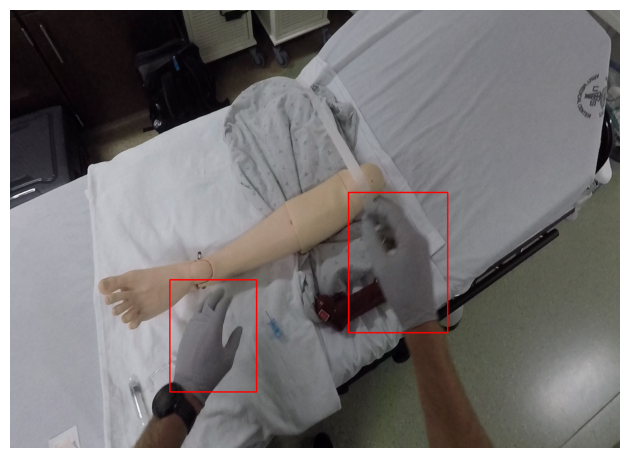

In [10]:
# sanity check
reshape_img_size = (1280, 920)
image_width, image_height = reshape_img_size
image_path = "/home/kevinteng/Desktop/dev/llm/personal_projects/healthcare/trauma_thompson/task2_hand_tracking/outputs/P03_10_frame_000000.jpg"
image = np.array(Image.open(image_path).convert("RGB"), dtype=np.uint8)
print(image.shape)
bboxes = []
txt_path = "/home/kevinteng/Desktop/dev/llm/personal_projects/healthcare/trauma_thompson/task2_hand_tracking/outputs/P03_10_frame_000000.txt"
with open(txt_path, "r") as f:
    lines = f.readlines()
for line in lines:
    parts = line.strip().split()
    if len(parts) != 5:
        continue

    class_id = int(parts[0])
    x_center, y_center, w, h = map(float, parts[1:])

    # Convert normalized → pixel coordinates
    x_center *= image_width
    y_center *= image_height
    w *= image_width
    h *= image_height

    # Get corner points
    x_min = int(x_center - w / 2)
    y_min = int(y_center - h / 2)
    x_max = int(x_center + w / 2)
    y_max = int(y_center + h / 2)
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

plt.imshow(image)
plt.axis("off")
plt.tight_layout()
plt.show()

---

# Execution

In this section, we will be creating dataset by retrieving the image at given frame <br> and resize the image frame to (1280, 920). The image will be stored based on the recommended structure by Ultralytics.

In [12]:
# list out all relevelant file paths and directories
output_dir = "/home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task2_hands/ultralytics_training"
csv_pth = "./outputs/info_df.csv"
anno_dir = (
    "/home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task2_hands/train/bbox"
)
video_dir = (
    "/home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task2_hands/train/videos"
)
save_img_dir = "/home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task2_hands/ultralytics_training/images"
save_anno_dir = "/home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task2_hands/ultralytics_training/labels"
resize_img_size = (1280, 920)

df = pd.read_csv(csv_pth)

error_df = []
print("Starting to process videos...")
for video_id in df["video_id"]:
    video_path = os.path.join(video_dir, f"{video_id}.mp4")
    anno_path = os.path.join(anno_dir, f"{video_id}")
    print(f"Processing video from: {video_path}")
    print(f"Annotations found in folder: {anno_path}")
    # the video width and height for resizing
    width = df.loc[df["video_id"] == video_id, "width"].values[0] 
    height = df.loc[df["video_id"] == video_id, "height"].values[0]
    # get split status
    split = df.loc[df["video_id"] == video_id, "split"].values[0]
    # create save directory
    save_img_dir_split = os.path.join(save_img_dir, split)
    save_anno_dir_split = os.path.join(save_anno_dir, split)
    if not os.path.exists(save_img_dir_split):
        os.makedirs(save_img_dir_split, exist_ok=True)
    if not os.path.exists(save_anno_dir_split):
        os.makedirs(save_anno_dir_split, exist_ok=True)
    # loop through the annotations correlated to the video id 
    # the annotations needed to be sorted to ensure the frame index is in sequence order
    for anno_json in sorted(glob(os.path.join(anno_path, "*.json"))):
        frame_index = int(os.path.basename(anno_json).replace(".json", "").split("_")[-1])
        try:
            # get the video frame and resize them
            get_video_frame(
                video_path,
                frame_index,
                output_dir=save_img_dir_split,
                resize_img_size=resize_img_size
            )
        except Exception as e:
            print(f"Error processing video {video_id} at frame {frame_index}: {e}")
            # log the error frames for inspection
            log_df = pd.DataFrame({"video_id": [video_id], "frame_index": [frame_index]})
            error_df.append(log_df)
            # no need to have converted .txt file if there is not frame
            continue
        # convert the annotation to yolo format
        convert_json_to_yolo_txt(
            anno_json,
            save_anno_dir_split,
            original_img_size=(width, height),
            resize_img_size=resize_img_size,
            one_category=False
        )
    print(f"Finished processing video: {video_id}")
    print("-"*100)

pd.concat(error_df, ignore_index=True).to_csv("./outputs/error_df.csv", index=False)


Starting to process videos...
Processing video from: /home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task2_hands/train/videos/P03_11.mp4
Annotations found in folder: /home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task2_hands/train/bbox/P03_11
Finished processing video: P03_11
----------------------------------------------------------------------------------------------------
Processing video from: /home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task2_hands/train/videos/P03_10.mp4
Annotations found in folder: /home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task2_hands/train/bbox/P03_10
Error processing video P03_10 at frame 2049: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Finished processing video: P03_10
----------------------------------------------------------------------------------------------------
Processing video from: /home/kevinteng/Desktop/dataset/trauma_th

Sanity check if the preprossed dataset matches

In [15]:
split = ["train", "val"]

for s in split:
    split_df = df.query(f"split == '{s}'")
    print(f"Checking {s} set")
    print(f"Number of videos: {split_df['n_annos'].sum()}")
    print()
print("-"*100)
print("Retrieved Data")
for s in split:
    img_dir = os.path.join(save_img_dir, s)
    anno_dir = os.path.join(save_anno_dir, s)
    print(f"Checking {s} set")
    print(f"Number of images: {len(os.listdir(img_dir))}")
    print(f"Number of annotations: {len(os.listdir(anno_dir))}")
    print()

Checking train set
Number of videos: 29156

Checking val set
Number of videos: 6807

----------------------------------------------------------------------------------------------------
Retrieved Data
Checking train set
Number of images: 29154
Number of annotations: 29154

Checking val set
Number of images: 6805
Number of annotations: 6805



2 frames were missing from train set and val set simultaneously and recorded in error_df.csv

In [16]:
error_df = pd.read_csv("./outputs/error_df.csv")
error_df

,video_id,frame_index
0,P03_10,2049
1,P03_08,2239
2,P03_22,1985
3,P03_03,2374


---

In [ ]:
def convert_json_to_yolo_txt_v2(
    json_path: str,
    output_dir: str,
    original_img_size: tuple[int, int],
    resize_img_size: tuple[int, int] = (1280, 920),
    one_category: bool = False,
) -> list:
    """
    Converts a hand bbox annotation JSON file to YOLO format .txt file (one line per bbox):
    YOLO format (class x_center y_center width height, all normalized [0,1])
    Assumes class 0 for hands. If img_width/height is not given, use video info if available.
    """
    # If output .txt path is not provided, replace .json with .txt
    img_name = os.path.basename(json_path).replace(".json", "")
    video_name = os.path.basename(os.path.dirname(json_path))
    txt_path = os.path.join(output_dir, f"{video_name}_{img_name}.txt")

    # First, try reading the image dimensions from the JSON ("image_width", "image_height")
    with open(json_path, "r") as f:
        data = json.load(f)

    img_width = original_img_size[0]
    img_height = original_img_size[1]
    img_width_reshape = resize_img_size[0]
    img_height_reshape = resize_img_size[1]
    img_width_reshape_ratio = img_width_reshape / img_width
    img_height_reshape_ratio = img_height_reshape / img_height
    lines = []
    id_list = []
    # The bboxes are usually in "annotations": [{"bbox": [x, y, w, h], ...}, ...]
    for ann in data.get("annotations", []):
        bbox = ann.get("bbox")
        id = ann.get("id")
        if bbox is None or len(bbox) != 4:
            continue
        x, y, w, h = bbox
        x = x * img_width_reshape_ratio
        y = y * img_height_reshape_ratio
        w = w * img_width_reshape_ratio
        h = h * img_height_reshape_ratio
        # Convert to YOLO: normalized center_x, center_y, width, height
        x_center = (x + w / 2) / img_width_reshape
        y_center = (y + h / 2) / img_height_reshape
        w_norm = w / img_width_reshape
        h_norm = h / img_height_reshape
        # Clamp between 0 and 1
        x_center = min(max(x_center, 0), 1)
        y_center = min(max(y_center, 0), 1)
        w_norm = min(max(w_norm, 0), 1)
        h_norm = min(max(h_norm, 0), 1)
        # class index (0), then the values
        if one_category:
            lines.append(f"{0} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}")
        else:
            lines.append(
                f"{id} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}"
            )
        id_list.append(id)
    
    with open(txt_path, "w") as f:
        f.write("\n".join(lines))
    return id_list

In [3]:
# list out all relevelant file paths and directories
output_dir = "/home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task2_hands/ultralytics_training"
csv_pth = "./outputs/info_df.csv"
anno_dir = (
    "/home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task2_hands/train/bbox"
)
video_dir = (
    "/home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task2_hands/train/videos"
)
save_img_dir = "/home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task2_hands/ultralytics_training/images"
save_anno_dir = "/home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task2_hands/ultralytics_training/labels"
resize_img_size = (1280, 920)

df = pd.read_csv(csv_pth)

print("Starting to process videos...")
output_dict = {}
output_dict["train"] = []
output_dict["val"] = []
for video_id in df["video_id"]:
    video_path = os.path.join(video_dir, f"{video_id}.mp4")
    anno_path = os.path.join(anno_dir, f"{video_id}")
    print(f"Processing video from: {video_path}")
    print(f"Annotations found in folder: {anno_path}")
    # the video width and height for resizing
    width = df.loc[df["video_id"] == video_id, "width"].values[0] 
    height = df.loc[df["video_id"] == video_id, "height"].values[0]
    # get split status
    split = df.loc[df["video_id"] == video_id, "split"].values[0]
    # create save directory
    save_img_dir_split = os.path.join(save_img_dir, split)
    save_anno_dir_split = os.path.join(save_anno_dir, split)
    if not os.path.exists(save_img_dir_split):
        os.makedirs(save_img_dir_split, exist_ok=True)
    if not os.path.exists(save_anno_dir_split):
        os.makedirs(save_anno_dir_split, exist_ok=True)
    # loop through the annotations correlated to the video id 
    # the annotations needed to be sorted to ensure the frame index is in sequence order
    for anno_json in sorted(glob(os.path.join(anno_path, "*.json"))):
        # convert the annotation to yolo format
        anno_id = convert_json_to_yolo_txt_v2(
            anno_json,
            save_anno_dir_split,
            original_img_size=(width, height),
            resize_img_size=resize_img_size,
            one_category=True # set only one class 
        )
        output_dict[split].extend(anno_id)
    print(f"Finished processing video: {video_id}")
    print("-"*100)

Starting to process videos...
Processing video from: /home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task2_hands/train/videos/P03_11.mp4
Annotations found in folder: /home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task2_hands/train/bbox/P03_11
Finished processing video: P03_11
----------------------------------------------------------------------------------------------------
Processing video from: /home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task2_hands/train/videos/P03_10.mp4
Annotations found in folder: /home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task2_hands/train/bbox/P03_10
Finished processing video: P03_10
----------------------------------------------------------------------------------------------------
Processing video from: /home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task2_hands/train/videos/P05_28.mp4
Annotations found in folder: /home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task2_hands/train/bbox/P05_28
Finished p

In [17]:
output_dict["train"] = [i for i in output_dict["train"] if i <= 1]
train_val, train_count = np.unique(output_dict["train"], return_counts=True)
val_val, val_count = np.unique(output_dict["val"], return_counts=True)

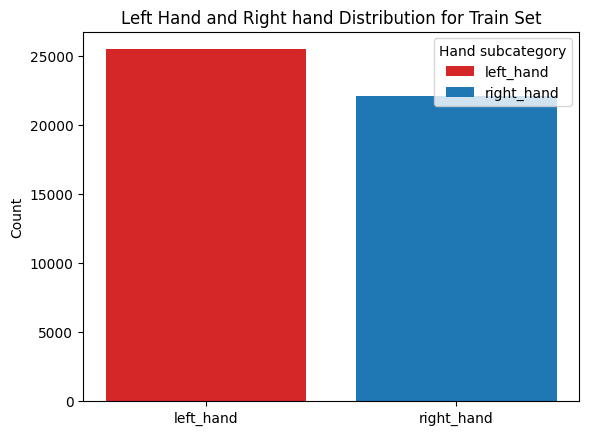

In [18]:
fig, ax = plt.subplots()

hand = np.where(train_val == 0, "left_hand", "right_hand")
counts = train_count
bar_labels = ['left_hand', 'right_hand']
bar_colors = ['tab:red', 'tab:blue']

ax.bar(hand, counts, label=bar_labels, color=bar_colors)

ax.set_ylabel('Count')
ax.set_title('Left Hand and Right hand Distribution for Train Set')
ax.legend(title='Hand subcategory')

plt.show()

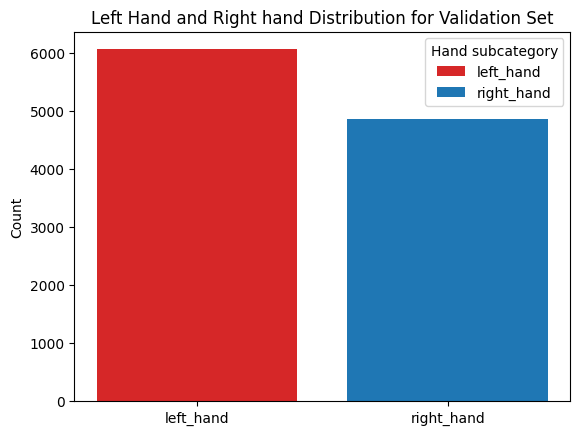

In [9]:
fig, ax = plt.subplots()

hand = np.where(val_val == 0, "left_hand", "right_hand")
counts = val_count
bar_labels = ['left_hand', 'right_hand']
bar_colors = ['tab:red', 'tab:blue']

ax.bar(hand, counts, label=bar_labels, color=bar_colors)

ax.set_ylabel('Count')
ax.set_title('Left Hand and Right hand Distribution for Validation Set')
ax.legend(title='Hand subcategory')

plt.show()